In [1]:
import pandas as pd
#Loading dataset
df = pd.read_csv(r"C:\Users\raymu\Downloads\Study\Data Science Projects\Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [2]:
# Checking dataset size, types, and label balance.
df.head()
df.info()
df.isna().sum()
df['Churn'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [20]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [3]:
# 1. Remove customerID (identifier) as it tells no information about the churn prediction
df = df.drop('customerID', axis=1)

# 2. Convert TotalCharges to numeric (it may be a string with blanks)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# fill any NaNs with median or 0
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# 3. Fix column name typos if present (my CSV has a truncated header 'Dependent...ng')
df.columns = [c.strip() for c in df.columns]  # remove whitespace


In [4]:
# binary map for target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Create tenure groups (example)
df['tenure_group'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 72],
                           labels=['0-12','12-24','24-48','48-72'])

# Create a simple charge ratio
df['charge_ratio'] = df['MonthlyCharges'] / (df['tenure'] + 1)

# One-hot encode categorical variables (drop_first to avoid collinearity)
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Churn']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['int64','float64']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [8]:
X.select_dtypes(include=['int64','float64']).columns.tolist()


['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'charge_ratio']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)

y_pred = log.predict(X_test)
y_proba = log.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.8460306388695136
F1: 0.5855855855855856
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [9]:
!pip install xgboost

  Using cached xgboost-3.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-win_amd64.whl (72.0 MB)


In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    # use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))


ROC-AUC: 0.8358095016662791
F1: 0.5882352941176471


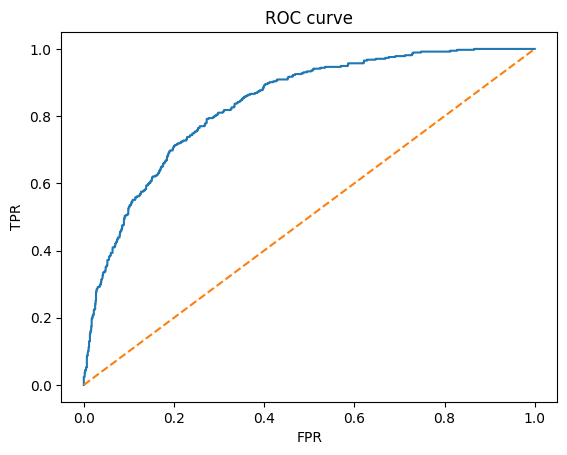

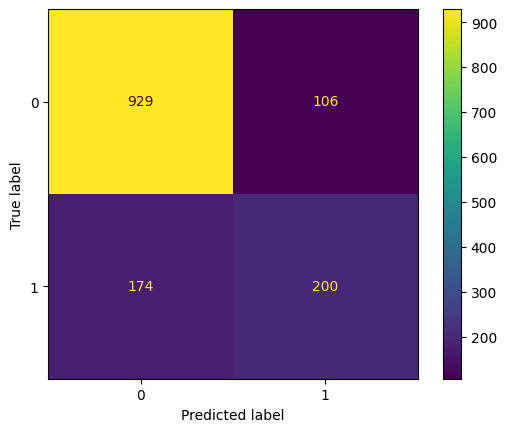

In [9]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [14]:
!pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   --------------------------------------- 549.1/549.1 kB 13.7 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------- ----------------------------- 10.5/38.1 MB 52.6 MB/s eta 0:00:01
   ---------------------- ----------------- 21.2/38.1 MB 50.9 MB/s eta 0:00:01
   ---------------------------------- ----- 32.8/38.1 MB 51.3 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.1 MB 51.2 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 38.1 MB/s eta 0:00:00
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)


In [2]:
pip install jupyterlab_widgets

   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   --------------------------------------- 914.9/914.9 kB 20.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import shap
shap.initjs()


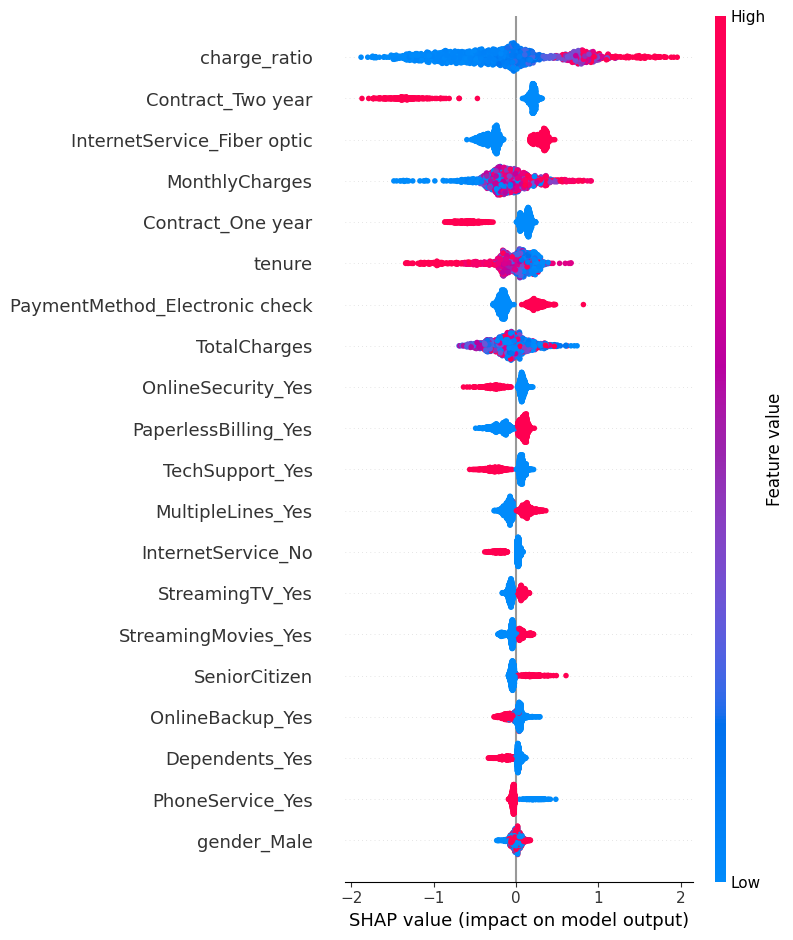

In [11]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)  # for tree models, or explainer(X_test)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_test)

# Force plot for a single customer (local explanation)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# choose threshold that gives required recall or precision


In [13]:
import os
os.makedirs("models", exist_ok=True)

import joblib
joblib.dump(xgb, "models/xgb_churn.pkl")
joblib.dump(scaler, "models/scaler.pkl")   

joblib.dump(df.drop(columns=['Churn']).columns.tolist(), "models/feature_columns.pkl")


['models/feature_columns.pkl']

In [14]:
df.drop(columns=['Churn']).columns.tolist()

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'charge_ratio',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'tenure_group_12-24',
 'tenure_group_24-48',
 'tenure_group_48-72']